# Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Przygotowanie odpowiednich danych

In [2]:
'''
Dla PoC wykonuje obliczenia dla:
 * '../data/DogsCats'
Folder docelowy:
 * '../data/Photos'
'''

dir_path = '../../data/Photos'
A_folder = 'originals'
B_folder = 'photoshops'

In [3]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import random
import os

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


# Stałe

In [4]:
# Wilkości

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Przygotowanie Danych

In [5]:
'''
Opis danych:
1 - klasa 1 -> Originals
0 - klasa 2 -> Photoshops
''' 

A_folder_list = os.listdir(dir_path + '/' + A_folder)
B_folder_list = os.listdir(dir_path + '/' + B_folder)

filenames = []
categories = []

for filename in A_folder_list:
    categories.append(0)
    filenames.append(dir_path + '/' + A_folder + '/' + filename)

for filename in B_folder_list:
    categories.append(1)
    filenames.append(dir_path + '/' + B_folder + '/' + filename)


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
# Mieszamy!
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
df.head()

,filename,category
0,../../data/Photos/originals/7ak2w6.jpg,0
1,../../data/Photos/originals/27lsoy.jpg,0
2,../../data/Photos/originals/7g0q9a.jpg,0
3,../../data/Photos/photoshops/da1jeqf_0.jpg,1
4,../../data/Photos/originals/4ioqrn.jpg,0


In [8]:
df.shape

(21758, 2)

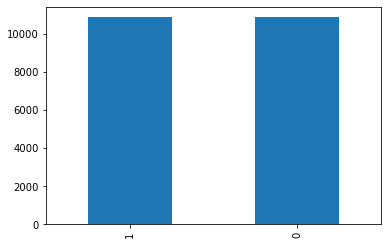

In [9]:
df['category'].value_counts().plot.bar()

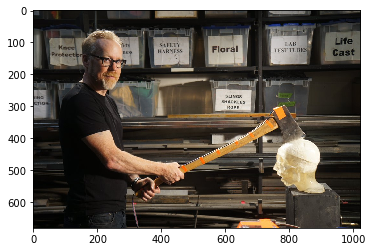

In [10]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)

# Obróbka zdjęć

In [11]:
from skimage.feature import hog
from skimage.color import rgb2gray

In [12]:
import mahotas
import cv2

def ft_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hu_moments = cv2.HuMoments(cv2.moments(image)).flatten()
    return hu_moments

def ft_haralick(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(image).mean(axis=0)
    return haralick

def ft_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # chanels: [0,1,2], bo mamy przestrzeń HSV
    # mask: None
    # histSize: [8, 8, 8], bin count, po 8 dla każdego z kanałów
    # ranges : [0, 256, 0, 256, 0, 256], wszystko dla każdego z 3 kanałów
    hist  = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def ft_hog(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features = hog(image, block_norm='L2-Hys', pixels_per_cell=(32, 32))
    return hog_features

def preprocess_image(image_path, hog=True):
    try:
        image = cv2.imread(image_path)
        image = cv2.resize(image, IMAGE_SIZE)
        histogram = ft_histogram(image)
        haralick = ft_haralick(image)
        hu = ft_hu_moments(image)
        if hog == True:
            hog = ft_hog(image)
            global_feature = numpy.hstack([histogram, haralick, hu, hog])
        elif hog == False:
            global_feature = numpy.hstack([histogram, haralick, hu])
        return global_feature
    except Exception as e:
        print(f'Problem with {image_path}, error_msg: {str(e)}')
    

# Przeliczenie Cech Zdjęć + Kategorii

In [13]:
g_f = []
g_f_n_h = []
l = []

for i in df['filename']:
    data_img = preprocess_image(i)
    data_img_no_hog = preprocess_image(i, hog=False)
    g_f.append(data_img)
    g_f_n_h.append(data_img_no_hog)

for i in df['category']:
    if i == 0:
        l.append('original')
    else:
        l.append('photoshop')

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

print(f'Wektor zdjęć z HOG: {numpy.array(g_f).shape}')
print(f'Wektor zdjęć bez HOG: {numpy.array(g_f_n_h).shape}')
print(f'Wektor kategorii słownych: {numpy.array(l).shape}\n')

# Label Encoder
# Koty - 0
# Psy - 1
targetNames = numpy.unique(l)
le = LabelEncoder()
target = le.fit_transform(l)

# Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features_gf = scaler.fit_transform(g_f)
rescaled_features_gfnh = scaler.fit_transform(g_f_n_h)

print(f'Wektor kategorii liczbowych: {target.shape}')
print(f'Skalowany wektor zdjęć z HOG: {numpy.array(rescaled_features_gf).shape}')
print(f'Skalowany wektor zdjęć bez HOG: {numpy.array(rescaled_features_gfnh).shape}\n')

print(f'Max arg z nieskalowanego(z HOG): {numpy.argmax(g_f[0])}, Min arg z nieskalowanego(z HOG): {numpy.argmin(g_f[0])}')
print(f'Max z nieskalowanego(z HOG): {numpy.amax(g_f[0])}, Min z nieskalowanego(z HOG): {numpy.amin(g_f[0])}\n')

print(f'Max arg z nieskalowanego(bez HOG): {numpy.argmax(g_f_n_h[0])}, Min arg z nieskalowanego(bez HOG): {numpy.argmin(g_f_n_h[0])}')
print(f'Max z nieskalowanego(bez HOG): {numpy.amax(g_f_n_h[0])}, Min z nieskalowanego(bez HOG): {numpy.amin(g_f_n_h[0])}\n')

print(f'Max arg z skalowanego(z HOG): {numpy.argmax(rescaled_features_gf[0])}, Min arg z skalowanego(z HOG): {numpy.argmin(rescaled_features_gf[0])}')
print(f'Max z skalowanego(z HOG): {numpy.amax(rescaled_features_gf[0])}, Min z skalowanego(z HOG): {numpy.amin(rescaled_features_gf[0])}\n')

print(f'Max arg z skalowanego(bez HOG): {numpy.argmax(rescaled_features_gfnh[0])}, Min arg z skalowanego(bez HOG): {numpy.argmin(rescaled_features_gfnh[0])}')
print(f'Max z skalowanego(bez HOG): {numpy.amax(rescaled_features_gfnh[0])}, Min z skalowanego(bez HOG): {numpy.amin(rescaled_features_gfnh[0])}')

Wektor zdjęć z HOG: (21758, 856)
Wektor zdjęć bez HOG: (21758, 532)
Wektor kategorii słownych: (21758,)

Wektor kategorii liczbowych: (21758,)
Skalowany wektor zdjęć z HOG: (21758, 856)
Skalowany wektor zdjęć bez HOG: (21758, 532)

Max arg z nieskalowanego(z HOG): 518, Min arg z nieskalowanego(z HOG): 523
Max z nieskalowanego(z HOG): 10392.166334376518, Min z nieskalowanego(z HOG): -0.2540566417231064

Max arg z nieskalowanego(bez HOG): 518, Min arg z nieskalowanego(bez HOG): 523
Max z nieskalowanego(bez HOG): 10392.166334376518, Min z nieskalowanego(bez HOG): -0.2540566417231064

Max arg z skalowanego(z HOG): 529, Min arg z skalowanego(z HOG): 39
Max z skalowanego(z HOG): 0.9795381910499288, Min z skalowanego(z HOG): 0.0

Max arg z skalowanego(bez HOG): 529, Min arg z skalowanego(bez HOG): 39
Max z skalowanego(bez HOG): 0.9795381910499288, Min z skalowanego(bez HOG): 0.0


# Zapis/Odczyt

In [15]:
import h5py

def save(features, labels, dataframe, name):
    h5f_data = h5py.File('data_' + str(name) + '.h5', 'w')
    h5f_data.create_dataset('dataset', data=numpy.array(features))

    h5f_label = h5py.File('labels_' + str(name) + '.h5', 'w')
    h5f_label.create_dataset('dataset', data=numpy.array(labels))

    h5f_data.close()
    h5f_label.close()

    dataframe.to_csv('dataframe_' + str(name) + '.csv')
    
def load(features, labels, dataframe):
    h5f_data  = h5py.File(features, 'r')
    h5f_label = h5py.File(labels, 'r')

    global_features_string = h5f_data['dataset']
    global_labels_string   = h5f_label['dataset']

    global_features = numpy.array(global_features_string)
    global_labels   = numpy.array(global_labels_string)

    h5f_data.close()
    h5f_label.close()
    
    df = pd.read_csv(dataframe, index_col = 0)  
    
    return global_features, global_labels, df
    
save(rescaled_features_gf, target, df, name='Casia_with_HOG')
save(rescaled_features_gfnh, target, df, name='Casia_without_HOG')

# B od BIG - więcej danych(z HOGiem), S - small(bez HOGa)
global_features_B, global_labels_B, df_B = load('data_Casia_with_HOG.h5', 'labels_Casia_with_HOG.h5', 'dataframe_Casia_with_HOG.csv')
global_features_S, global_labels_S, df_S = load('data_Casia_without_HOG.h5', 'labels_Casia_without_HOG.h5', 'dataframe_Casia_without_HOG.csv')

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
global_features_B_PCA = pca.fit_transform(global_features_B)
global_features_S_PCA = pca.fit_transform(global_features_S)

save(global_features_B_PCA, target, df, name='Casia_with_HOG_with_PCA')
save(global_features_S_PCA, target, df, name='Casia_without_HOG_without_PCA')

# B od BIG - więcej danych(z HOGiem), S - small(bez HOGa)
global_features_B_PCA, global_labels_B_PCA, df_B_PCA = load('data_Casia_with_HOG_with_PCA.h5', 'labels_Casia_with_HOG_with_PCA.h5', 'dataframe_Casia_with_HOG_with_PCA.csv')
global_features_S_PCA, global_labels_S_PCA, df_S_PCA = load('data_Casia_without_HOG_without_PCA.h5', 'labels_Casia_without_HOG_without_PCA.h5', 'dataframe_Casia_without_HOG_without_PCA.csv')

In [17]:
print(f'Z HOG:')
print(f'\t Wektor zdjęć: {global_features_B.shape}')
print(f'\t Wektor kategorii słownych: {global_labels_B.shape}\n')
print(f'\t Wektor dataframe: {df_B.shape}\n\n')


print(f'BEZ HOG:')
print(f'\t Wektor zdjęć: {global_features_S.shape}')
print(f'\t Wektor kategorii słownych: {global_labels_S.shape}\n')
print(f'\t Wektor dataframe: {df_S.shape}\n')


print(f'Z HOG + PCA:')
print(f'\t Wektor zdjęć: {global_features_B_PCA.shape}')
print(f'\t Wektor kategorii słownych: {global_labels_B_PCA.shape}\n')
print(f'\t Wektor dataframe: {df_B_PCA.shape}\n\n')


print(f'BEZ HOG + PCA:')
print(f'\t Wektor zdjęć: {global_features_S_PCA.shape}')
print(f'\t Wektor kategorii słownych: {global_labels_S_PCA.shape}\n')
print(f'\t Wektor dataframe: {df_S_PCA.shape}\n')

Z HOG:
	 Wektor zdjęć: (21758, 856)
	 Wektor kategorii słownych: (21758,)

	 Wektor dataframe: (21758, 2)


BEZ HOG:
	 Wektor zdjęć: (21758, 532)
	 Wektor kategorii słownych: (21758,)

	 Wektor dataframe: (21758, 2)

Z HOG + PCA:
	 Wektor zdjęć: (21758, 20)
	 Wektor kategorii słownych: (21758,)

	 Wektor dataframe: (21758, 2)


BEZ HOG + PCA:
	 Wektor zdjęć: (21758, 20)
	 Wektor kategorii słownych: (21758,)

	 Wektor dataframe: (21758, 2)



In [18]:
df_B.head()

,filename,category
0,../../data/Photos/originals/7ak2w6.jpg,0
1,../../data/Photos/originals/27lsoy.jpg,0
2,../../data/Photos/originals/7g0q9a.jpg,0
3,../../data/Photos/photoshops/da1jeqf_0.jpg,1
4,../../data/Photos/originals/4ioqrn.jpg,0


In [19]:
df_S.head()

,filename,category
0,../../data/Photos/originals/7ak2w6.jpg,0
1,../../data/Photos/originals/27lsoy.jpg,0
2,../../data/Photos/originals/7g0q9a.jpg,0
3,../../data/Photos/photoshops/da1jeqf_0.jpg,1
4,../../data/Photos/originals/4ioqrn.jpg,0


# Funkcję liczące statystyki

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score

def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [21]:
from mlxtend.plotting import plot_confusion_matrix

def plot_cm(cm, classes):
    plot_confusion_matrix(conf_mat=cm,
                          colorbar=True, 
                          show_absolute=True,
                          show_normed=True,
                          class_names=classes)

# Funkcje do liczenia modelu

In [22]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

In [23]:
from sklearn.svm import SVC
from sklearn import clone
import copy
from tabulate import tabulate
from scipy.stats import ttest_ind

def do_the_thing(features, labels):
    
    clf_list = {
        "SVM linear": [],
        "SVM poly": [],
        "SVM rbf": [],
        "SVM sigmoid": []
    }
    
    tcm_list = copy.deepcopy(clf_list)
    tAccuracy_list = copy.deepcopy(clf_list)
    tPrecision_list = copy.deepcopy(clf_list)
    tRecall_list = copy.deepcopy(clf_list)
    tFScore_list = copy.deepcopy(clf_list)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=odp)
    clfs = {
        "SVM linear": SVC(kernel='linear', probability=True, random_state=odp, verbose=True),
        "SVM poly": SVC(kernel='poly', probability=True, random_state=odp, verbose=True),
        "SVM rbf": SVC(kernel='rbf', probability=True, random_state=odp, verbose=True),
        "SVM sigmoid": SVC(kernel='sigmoid', probability=True, random_state=odp, verbose=True),
    }
    scores = numpy.zeros((len(clfs), 5))
    
    for fold_id, (train_index, test_index) in enumerate(kf.split(features, labels)):
        for clf_idx, clf_name in enumerate(clfs):
            clf = clone(clfs[clf_name])
            clf.fit(features[train_index], labels[train_index])
            y_pred = clf.predict(features[test_index])

            accuracy, precision, recall, fscore = countStats(labels[test_index], y_pred)
            cm = confusion_matrix(labels[test_index], y_pred)
            scores[clf_idx, fold_id] = accuracy_score(labels[test_index], y_pred)

            tAccuracy_list[clf_name].append(accuracy)
            tPrecision_list[clf_name].append(precision)
            tRecall_list[clf_name].append(recall)
            tFScore_list[clf_name].append(fscore)
            tcm_list[clf_name].append(cm)

    
    print(f'\n\nKształt danych:')
    print(f'\t X_train: {features[train_index].shape}')
    print(f'\t X_test: {features[test_index].shape}')
    print(f'\t y_train: {labels[train_index].shape}')
    print(f'\t y_test: {labels[test_index].shape}')
    
    results = []
    
    for elem in clf_list:
        accuracy_m = numpy.mean(tAccuracy_list[elem])
        precision_m = numpy.mean(tPrecision_list[elem])
        recall_m = numpy.mean(tRecall_list[elem])
        fscore_m = numpy.mean(tFScore_list[elem])
        
        accuracy_std = numpy.std(tAccuracy_list[elem])
        precision_std = numpy.std(tPrecision_list[elem])
        recall_std = numpy.std(tRecall_list[elem])
        fscore_std = numpy.std(tFScore_list[elem])
        
        cm = sum(tcm_list[elem])
        
        res = [str(elem), 
               f'{accuracy_m:.3f} ({accuracy_std:.2f})',
               f'{precision_m:.3f} ({precision_std:.2f})',
               f'{recall_m:.3f} ({recall_std:.2f})',
               f'{fscore_m:.3f} ({fscore_std:.2f})',
               f'{cm}']
        results.append(res)

    printmd(f'### Rezultaty:')
        
    headers = ["Kernel", "Accuracy", "Precision", "Recall", "Fscore", "CM"]
    print('\n')
    print(tabulate(results, headers=headers))
    
    
    printmd(f'### Analiza statystyczna:')
    
    alfa = .05
    t_statistic = numpy.zeros((len(clfs), len(clfs)))
    p_value = numpy.zeros((len(clfs), len(clfs)))

    for i in range(len(clfs)):
        for j in range(len(clfs)):
            t_statistic[i, j], p_value[i, j] = ttest_ind(scores[i], scores[j])
    headers = ["SVM linear", "SVM poly", "SVM rbf", "SVM sigmoid"]
    names_column = numpy.array([["SVM linear"], ["SVM poly"], ["SVM rbf"], ["SVM sigmoid"]])
    t_statistic_table = numpy.concatenate((names_column, t_statistic), axis=1)
    t_statistic_table = tabulate(t_statistic_table, headers, floatfmt=".2f")
    p_value_table = numpy.concatenate((names_column, p_value), axis=1)
    p_value_table = tabulate(p_value_table, headers, floatfmt=".2f")
    printmd("**t-statistic:**")
    print(t_statistic_table)
    printmd("**p-value:**")
    print(p_value_table)
    
    
    advantage = numpy.zeros((len(clfs), len(clfs)))
    advantage[t_statistic > 0] = 1
    advantage_table = tabulate(numpy.concatenate(
        (names_column, advantage), axis=1), headers)
    printmd("**Przewaga:**")
    print(advantage_table)
    
    
    significance = numpy.zeros((len(clfs), len(clfs)))
    significance[p_value <= alfa] = 1
    significance_table = tabulate(numpy.concatenate(
        (names_column, significance), axis=1), headers)
    printmd("**Różnice statystycznie znaczące (alpha = 0.05):**")
    print(significance_table)
    
    
    stat_better = significance * advantage
    stat_better_table = tabulate(numpy.concatenate(
        (names_column, stat_better), axis=1), headers)
    printmd("**Wynik końcowy analizy statystycznej:**")
    print(stat_better_table)

# HOG

In [24]:
do_the_thing(global_features_B, global_labels_B)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Kształt danych:
	 X_train: (17407, 856)
	 X_test: (4351, 856)
	 y_train: (17407,)
	 y_test: (4351,)


### Rezultaty:



Kernel       Accuracy      Precision     Recall        Fscore        CM
-----------  ------------  ------------  ------------  ------------  -------------
SVM linear   0.590 (0.01)  0.591 (0.01)  0.590 (0.01)  0.589 (0.01)  [[7025 3854]
                                                                      [5061 5818]]
SVM poly     0.581 (0.00)  0.582 (0.00)  0.581 (0.00)  0.579 (0.00)  [[6922 3957]
                                                                      [5167 5712]]
SVM rbf      0.592 (0.01)  0.593 (0.01)  0.592 (0.01)  0.591 (0.00)  [[7015 3864]
                                                                      [5017 5862]]
SVM sigmoid  0.523 (0.00)  0.523 (0.00)  0.523 (0.00)  0.523 (0.00)  [[5758 5121]
                                                                      [5264 5615]]


### Analiza statystyczna:

**t-statistic:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear           0.00        3.27      -0.43          20.14
SVM poly            -3.27        0.00      -3.79          22.33
SVM rbf              0.43        3.79       0.00          20.56
SVM sigmoid        -20.14      -22.33     -20.56           0.00


**p-value:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear           1.00        0.01       0.68           0.00
SVM poly             0.01        1.00       0.01           0.00
SVM rbf              0.68        0.01       1.00           0.00
SVM sigmoid          0.00        0.00       0.00           1.00


**Przewaga:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           1          0              1
SVM poly                0           0          0              1
SVM rbf                 1           1          0              1
SVM sigmoid             0           0          0              0


**Różnice statystycznie znaczące (alpha = 0.05):**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           1          0              1
SVM poly                1           0          1              1
SVM rbf                 0           1          0              1
SVM sigmoid             1           1          1              0


**Wynik końcowy analizy statystycznej:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           1          0              1
SVM poly                0           0          0              1
SVM rbf                 0           1          0              1
SVM sigmoid             0           0          0              0


# Bez HOG

In [25]:
do_the_thing(global_features_S, global_labels_S)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Kształt danych:
	 X_train: (17407, 532)
	 X_test: (4351, 532)
	 y_train: (17407,)
	 y_test: (4351,)


### Rezultaty:



Kernel       Accuracy      Precision     Recall        Fscore        CM
-----------  ------------  ------------  ------------  ------------  -------------
SVM linear   0.584 (0.01)  0.588 (0.01)  0.584 (0.01)  0.579 (0.01)  [[7510 3369]
                                                                      [5686 5193]]
SVM poly     0.586 (0.01)  0.589 (0.01)  0.586 (0.01)  0.581 (0.01)  [[7489 3390]
                                                                      [5625 5254]]
SVM rbf      0.588 (0.01)  0.593 (0.01)  0.588 (0.01)  0.582 (0.01)  [[7670 3209]
                                                                      [5757 5122]]
SVM sigmoid  0.585 (0.01)  0.589 (0.01)  0.585 (0.01)  0.581 (0.01)  [[7410 3469]
                                                                      [5554 5325]]


### Analiza statystyczna:

**t-statistic:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear           0.00       -0.37      -0.94          -0.30
SVM poly             0.37        0.00      -0.45           0.07
SVM rbf              0.94        0.45       0.00           0.55
SVM sigmoid          0.30       -0.07      -0.55           0.00


**p-value:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear           1.00        0.72       0.38           0.77
SVM poly             0.72        1.00       0.66           0.95
SVM rbf              0.38        0.66       1.00           0.60
SVM sigmoid          0.77        0.95       0.60           1.00


**Przewaga:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           0          0              0
SVM poly                1           0          0              1
SVM rbf                 1           1          0              1
SVM sigmoid             1           0          0              0


**Różnice statystycznie znaczące (alpha = 0.05):**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           0          0              0
SVM poly                0           0          0              0
SVM rbf                 0           0          0              0
SVM sigmoid             0           0          0              0


**Wynik końcowy analizy statystycznej:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           0          0              0
SVM poly                0           0          0              0
SVM rbf                 0           0          0              0
SVM sigmoid             0           0          0              0


# HOG -> PCA

In [26]:
do_the_thing(global_features_B_PCA, global_labels_B_PCA)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Kształt danych:
	 X_train: (17407, 20)
	 X_test: (4351, 20)
	 y_train: (17407,)
	 y_test: (4351,)


### Rezultaty:



Kernel       Accuracy      Precision     Recall        Fscore        CM
-----------  ------------  ------------  ------------  ------------  -------------
SVM linear   0.569 (0.00)  0.569 (0.00)  0.569 (0.00)  0.568 (0.00)  [[6661 4218]
                                                                      [5165 5714]]
SVM poly     0.539 (0.01)  0.539 (0.01)  0.539 (0.01)  0.538 (0.01)  [[6393 4486]
                                                                      [5549 5330]]
SVM rbf      0.555 (0.00)  0.555 (0.00)  0.555 (0.00)  0.555 (0.00)  [[5981 4898]
                                                                      [4790 6089]]
SVM sigmoid  0.518 (0.00)  0.518 (0.00)  0.518 (0.00)  0.518 (0.00)  [[5712 5167]
                                                                      [5321 5558]]


### Analiza statystyczna:

**t-statistic:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear           0.00        7.40       7.30          17.77
SVM poly            -7.40        0.00      -4.13           4.73
SVM rbf             -7.30        4.13       0.00          14.22
SVM sigmoid        -17.77       -4.73     -14.22           0.00


**p-value:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear           1.00        0.00       0.00           0.00
SVM poly             0.00        1.00       0.00           0.00
SVM rbf              0.00        0.00       1.00           0.00
SVM sigmoid          0.00        0.00       0.00           1.00


**Przewaga:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           1          1              1
SVM poly                0           0          0              1
SVM rbf                 0           1          0              1
SVM sigmoid             0           0          0              0


**Różnice statystycznie znaczące (alpha = 0.05):**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           1          1              1
SVM poly                1           0          1              1
SVM rbf                 1           1          0              1
SVM sigmoid             1           1          1              0


**Wynik końcowy analizy statystycznej:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           1          1              1
SVM poly                0           0          0              1
SVM rbf                 0           1          0              1
SVM sigmoid             0           0          0              0


# Bez HOG -> PCA

In [27]:
do_the_thing(global_features_S_PCA, global_labels_S_PCA)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Kształt danych:
	 X_train: (17407, 20)
	 X_test: (4351, 20)
	 y_train: (17407,)
	 y_test: (4351,)


### Rezultaty:



Kernel       Accuracy      Precision     Recall        Fscore        CM
-----------  ------------  ------------  ------------  ------------  -------------
SVM linear   0.579 (0.01)  0.581 (0.01)  0.579 (0.01)  0.577 (0.01)  [[7150 3729]
                                                                      [5423 5456]]
SVM poly     0.568 (0.01)  0.569 (0.01)  0.568 (0.01)  0.565 (0.01)  [[7009 3870]
                                                                      [5536 5343]]
SVM rbf      0.572 (0.01)  0.574 (0.01)  0.572 (0.01)  0.569 (0.01)  [[7118 3761]
                                                                      [5557 5322]]
SVM sigmoid  0.513 (0.01)  0.513 (0.01)  0.513 (0.01)  0.513 (0.01)  [[5568 5311]
                                                                      [5279 5600]]


### Analiza statystyczna:

**t-statistic:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear           0.00        1.84       1.33           9.25
SVM poly            -1.84        0.00      -0.69           7.52
SVM rbf             -1.33        0.69       0.00           8.75
SVM sigmoid         -9.25       -7.52      -8.75           0.00


**p-value:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear           1.00        0.10       0.22           0.00
SVM poly             0.10        1.00       0.51           0.00
SVM rbf              0.22        0.51       1.00           0.00
SVM sigmoid          0.00        0.00       0.00           1.00


**Przewaga:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           1          1              1
SVM poly                0           0          0              1
SVM rbf                 0           1          0              1
SVM sigmoid             0           0          0              0


**Różnice statystycznie znaczące (alpha = 0.05):**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           0          0              1
SVM poly                0           0          0              1
SVM rbf                 0           0          0              1
SVM sigmoid             1           1          1              0


**Wynik końcowy analizy statystycznej:**

               SVM linear    SVM poly    SVM rbf    SVM sigmoid
-----------  ------------  ----------  ---------  -------------
SVM linear              0           0          0              1
SVM poly                0           0          0              1
SVM rbf                 0           0          0              1
SVM sigmoid             0           0          0              0
